# Understanding and Predicting Employee Turnover

### Objective
- To understand what factor contributed most to employee turnover
- To perform clustering to find any meaning patterns of employee traits
- To create a model that predicts the likelihood if a certain employee will leave the company or not
- To create or improve different retention strategies on targeted employees

The implementation of this model allows management to create better decision-making actions

### The Problem
One of the most common problems at work is **Turnover**. Replacing a worker earning about **50,000 dollars** cost the company about **10,000 dollars** or 20% of that worker's yearly income accoording to the Center of American Progress.

Replacing a high-level employee can cost multiple of that 

**Cost include:**

- Cost of off-boarding
- Cost of hiring (advertising, interviewing, hiring)
- Cost of onboarding a new person (training, management time)
- Lost productivity (a new person may take 1-2 years to reach the productivity of an existing person)

**Annual Cost of Turnover** = (Hiring + Onboarding + Development + Unfilled Time) * (Number of Employee X Annual Turnover Percentage)

**Annual Cost of Turnover** = (1000 + 500) X (15,000 * 24%)

**Annual Cost of Turnover** = 1500 X 3600

**Annual Cost of Turnover** = 5400000 

In [116]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Importing Helper File

In [136]:
import sys
import os
helper_dir = os.path.join('..','HelperFunction')
sys.path.append(helper_dir)
import HelperFunction as helpers
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Packages

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from functools import reduce

### Load the data

In [119]:
df = helpers.load_data("data/HR-data.csv.txt", format = "csv")
## Rename columns for better readablity 
df = helpers.renaming_column(df)
# Examine the Data
df.head()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Exploratory Data Analysis

In [124]:
## --- How many employees are in the dataset
df.shape

(14999, 10)

In [125]:
## -- Calculate the turnover rate of our company.
turnover_rate = df.turnover.value_counts()/df.shape[0]
turnover_rate

0    0.761917
1    0.238083
Name: turnover, dtype: float64

Imbalenced dataset. We need to take care of this before training the model

### Imbalanced Datasets:

There are many ways of dealing with imbalenced data. We will focus in the following approches before training our model in the `Modeling Notebook`:
1. Oversampling – SMOTE
2. Undersampling – RandomUnderSampler



In [126]:
### --- Display the mean summary of Employees (Turnover Vs. Non-turnover). What do we notice between groups
turnover_summary = df.groupby('turnover')
turnover_summary.mean()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


### Observation
We notice that people who left the company has approximately **44%** satisfaction while people who stayed has **66%** satisfication on average.

### Correlation between each features

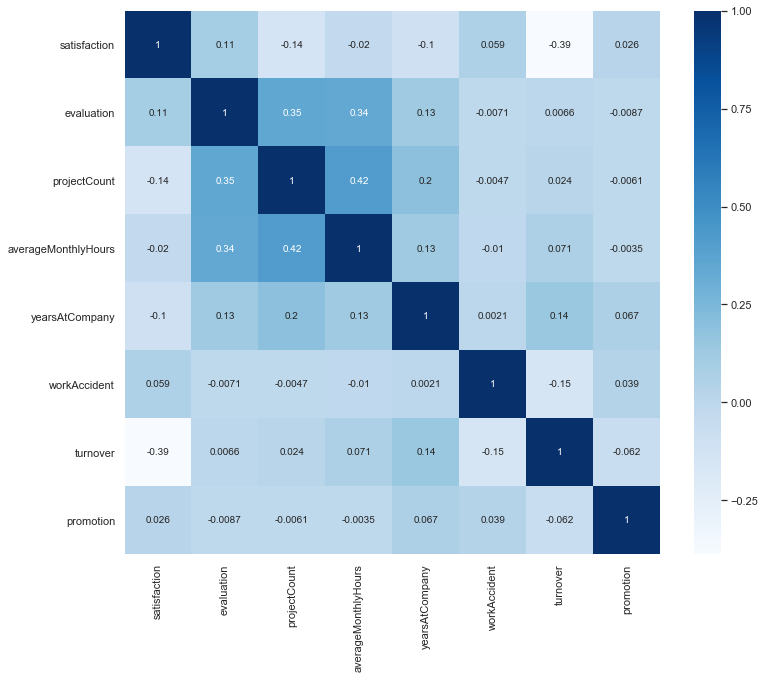

In [127]:
### --- What features cooelate the most with turnover
helpers.correlation_map(df.corr())
plt.savefig('sample.png')

### Observation
We notice that the lowest satisfcation leads to the higher turnover. 

### Distribution of Satisfaction, Evaluation and Project Count

**Summary:** 

**Satisfaction vs Employee Count:** There is a bimodal distribution. From our sample data, we have employee who are really dissatified indicating satifaction rate of **.2** whereas we also have employees who are really happy  and has satisfaction rate **(0.6~1)**.

**Evaluation vs Employee Count:** We see a clear separation in regards to employee being evaluated. We have people 
**<.6** and also people who belong **0.7~0.8**. It indicates that half employee are sad and the other half are really enjoying working at this company.

**Average Monthly Hours vs. Employee Count:** There are employees who works less than 150 hours a month and more than 200 hours a month.

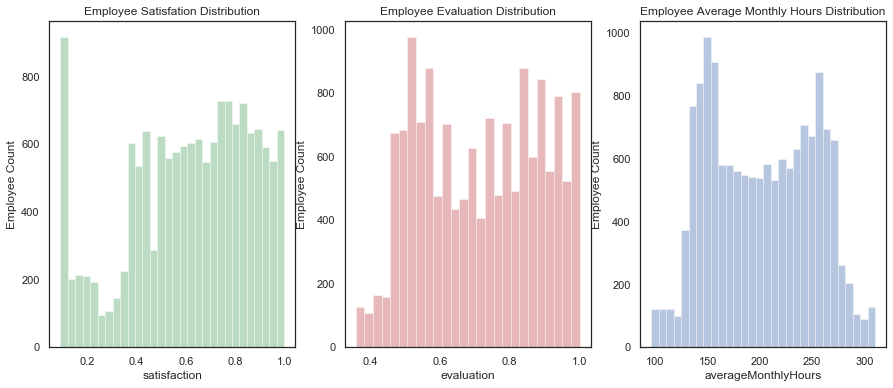

In [128]:
helpers.plot_feature(data = [df.satisfaction, df.evaluation, df.averageMonthlyHours], 
                     ylabel='Employee Count',
                     title = ['Employee Satisfation Distribution',
                              'Employee Evaluation Distribution', 
                              'Employee Average Monthly Hours Distribution'], 
                     kind = 'distplot')

### Satisfaction VS. Evaulation

- There are **3** distinct clusters for employee who left the company.

**Cluster 1 (Hard-Working and Sad Employee):** Satisfaction was below 0.2 and evaluations were greater than 0.75 which could be a good indication that employees who left the company were good workers but felt horrible at the job.

- **Question** What could be the reason for feeling so horrible when you are highly evaluated? Could it be working too hard? Could this cluster mean employees who are "overworked"?

**Cluster 2 (Bad and Sad Employee):** Satisfaction between about 0.35~0.45 and evaluations below ~0.58. This could be seen as employees who were badly evaluated and felt bad at work.

- **Question** Could this cluster mean employees who "under-performed"?

**Cluster 3 (Hard-Working and Happy Employee):** Satisfaction between 0.7~1.0 and evaluations were greater than 0.8. Which could mean that employees in this cluster were "ideal". They loved their work and were evaluated highly for their performance. 

- **Question** Could this cluster mean that employees left beacuse they found another job opportunity 

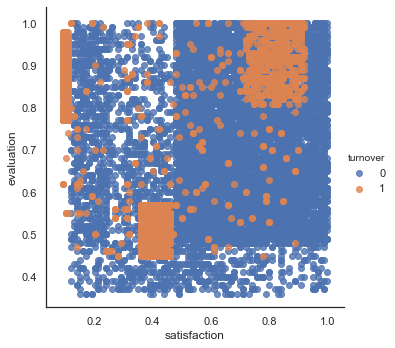

In [129]:
helpers.plot_feature(data = df, 
                     x = 'satisfaction', 
                     y='evaluation',
                     hue = 'turnover', 
                     kind = 'lmplot')

### K-Means Clustering of Employee Turnover 

   **Cluster 1 (Blue):** Hard-working and Sad Employees

   **Cluster 2 (Red):** Bad and Sad Employee.

   **Cluster 3 (Green):** Hard-working and Happy Employee

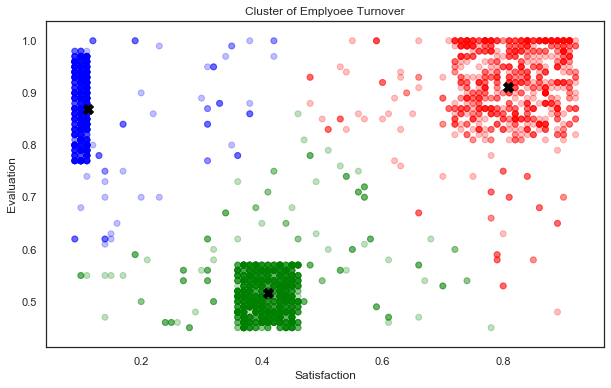

In [130]:
## -- Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3, random_state=2)
kmeans.fit(df[df.turnover==1][['satisfaction', 'evaluation']])


kmeans_colors = ['green' if c == 0 else 'blue' if c ==2 else 'red' for c in kmeans.labels_]

fig = plt.figure(figsize = (10, 6))
plt.scatter(data = df[df.turnover==1], 
            x = 'satisfaction', 
            y = 'evaluation', 
            alpha=0.25, 
            color = kmeans_colors)

plt.scatter(x = kmeans.cluster_centers_[:,0],
            y = kmeans.cluster_centers_[:,1],
            color = 'black', 
            marker = 'X', 
            s =100)

plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")
plt.title("Cluster of Emplyoee Turnover");

### Employee Satisfaction

There is a **tri-modal** distribution for employees that turnovered

- Employees who had really low satisfaction level **(0.2 or less)** left the company more 
- Employees who had low satifaction levels **(0.3~0.5)** left the company more
- Employess who had really high satifaction levels **(0.7 or more)** left the company more

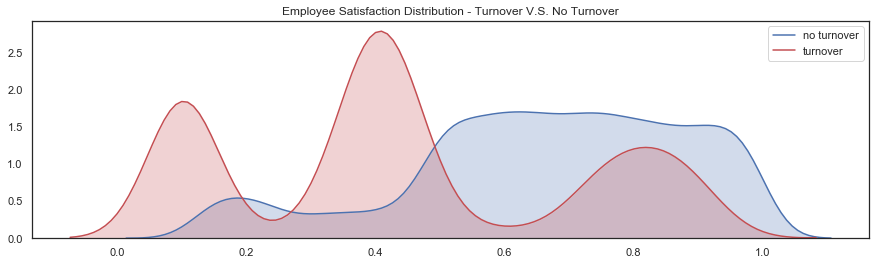

In [131]:
#KDEPlot: Kernel Density Estimate Plot
helpers.plot_feature(data = [df.loc[(df['turnover']==0), 'satisfaction'], 
                     df.loc[(df['turnover']==1), 'satisfaction']],
             legend = ['no turnover', 'turnover'],
             title = 'Employee Satisfaction Distribution - Turnover V.S. No Turnover',
             kind = 'kde')

### Employee Project Count

Summary: 

- More than half of employees with **2, 6 and 7** projects left the company
- Majority of the employees who did not leave the company had **3,4,and 5** projects
- All of the employees with **7** projects left the company
- There is an increase in employee turnover rate as project count increases

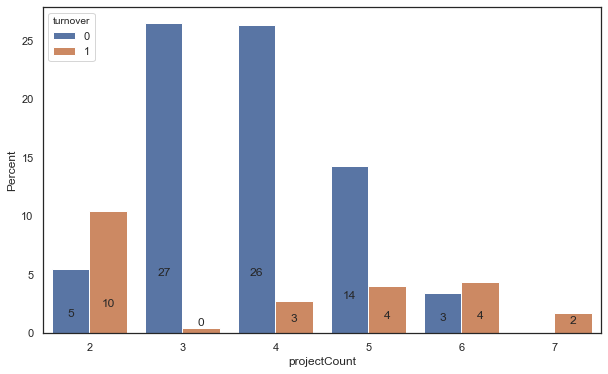

In [137]:
helpers.plot_feature(data = df, 
             x = "projectCount", 
             y = "projectCount", 
             hue = "turnover", 
             kind = 'bar',
             ylabel = "Percent")

### Employee Department Distribuition

In [84]:
## Create a Data of employee left and stay and total
hr_left = pd.DataFrame(df[df.turnover == 1].department.value_counts()).reset_index()
hr_stay = pd.DataFrame(df[df.turnover == 0].department.value_counts()).reset_index()
hr_total = pd.DataFrame(df.department.value_counts()).reset_index()
## Merge three DataFrame
hr_merge = reduce(lambda df1, df2: pd.merge(df1, df2, on = 'index'), [hr_left, hr_stay, hr_total])
## Renaming Columns
hr_merge = hr_merge.rename(columns = {'department_x': 'left', 'department_y': 'stay', 
                                      'index': 'department', 'department': 'Total'})
hr_merge

,department,left,stay,Total
0,sales,1014,3126,4140
1,technical,697,2023,2720
2,support,555,1674,2229
3,IT,273,954,1227
4,hr,215,524,739
5,accounting,204,563,767
6,marketing,203,655,858
7,product_mng,198,704,902
8,RandD,121,666,787
9,management,91,539,630


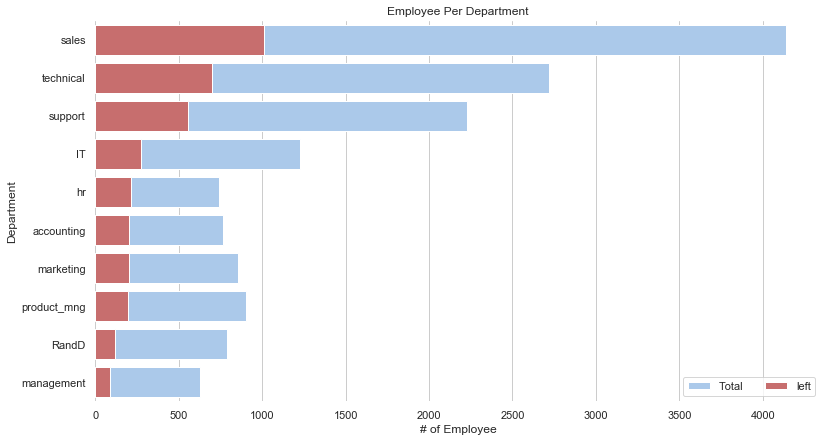

In [85]:
helpers.plot_feature(data = hr_merge,
             x = ['Total', 'left'], 
             ylabel= 'Department', 
             xlabel="# of Employee", 
             title="Employee Per Department",
             kind = 'barh',)

We notice that the sales, technical and support team has the highes turnover rate. 

### Average Monthly Hours

Summary: 

- A bimodal distribution for employees that turnovered
- Employees who had less hours of work **(~150 hours or less)** left the company more
- Employees who had too many hours of work **(~250 or more)** left the company
- Employees who left generarlly were **underworked** or **overworked**

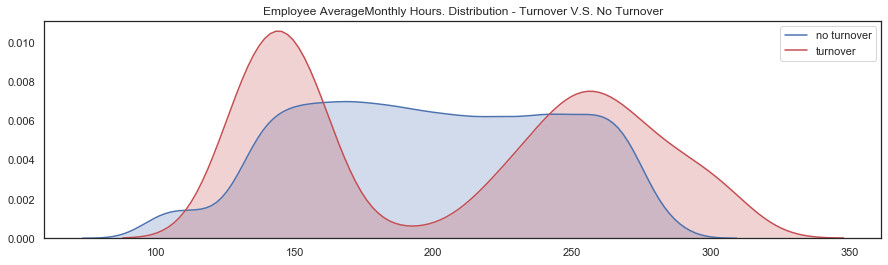

In [86]:
helpers.plot_feature(data = [df.loc[(df['turnover']==0), 'averageMonthlyHours'], 
                     df.loc[(df['turnover']==1), 'averageMonthlyHours']],
                     legend = ['no turnover', 'turnover'],
                     title = 'Employee AverageMonthly Hours. Distribution - Turnover V.S. No Turnover',
                     kind = 'kde')

### Class Imbalance

#### Employee Turnover Rate: 24%

In [87]:
df.turnover.value_counts(normalize=True)

0    0.761917
1    0.238083
Name: turnover, dtype: float64

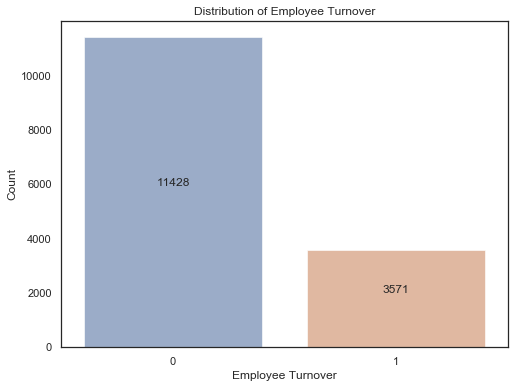

In [88]:
turnover = df.turnover.value_counts()
helpers.plot_feature(x = turnover.index, y = turnover.values,
                     xlabel = 'Employee Turnover', ylabel = 'Count',
                     title = 'Distribution of Employee Turnover', kind = 'simple bar')